# IA Assignment 2 - Supervised Learning

## AirLine Delays

> Airlines Dataset Inspired in the regression dataset from Elena Ikonomovska. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

## 1. Dataset Preparation and Preprocessing

### 1.1 Data Visualization and Exploratory Data Analysis

In [109]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.met    rics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("Data/airlines_delay.csv")

In [110]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [111]:
df.dtypes

Flight         float64
Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object

In [112]:
df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


Only shows values for numerical colums, this means that information regarding the columns **Airline**, **AirportFrom** and  **AirportTo** is not being displayed.

Here we can already spot some outliers since no flight should have length 0. We will need to remove those later.

In [113]:
df.isna().any()

Flight         False
Time           False
Length         False
Airline        False
AirportFrom    False
AirportTo      False
DayOfWeek      False
Class          False
dtype: bool

There is no **Null** or **NA** values

In [114]:
df.nunique()

Flight         6585
Time           1131
Length          426
Airline          18
AirportFrom     293
AirportTo       293
DayOfWeek         7
Class             2
dtype: int64

In [115]:
if set(df['AirportFrom'].unique()) == set(df['AirportFrom'].unique()):
    print("Same list of Airports")
else:
    print("Different List of Airports")

Same list of Airports


After this quick analysis, where is the information we have:

The dataset contains 8 columns:
 - Flight: Number of the flight. Probably an ID, but not unique, since, from what we read, the flight numbers can be repeated.
 - Time: Time of departure. Ranges from 10 to 1439. The creator of the dataset specified in one of the comments in Kaggle that it is in minutes, where 1439 is equivalent to 23:59 for example
 - Length: Length of the flight in minutes. Length has some zero values that need to be removed
 - Airline: Id of the Airline that operated the flight.
 - AirportFrom and AirportTo: The origin and destinations airports. The list of airports is the same.
 - DayOfWeek: Day of the week, where 1 is Monday and 7 is Sunday according to the creator of the dataset
 - Class: Binary target variable, where 1 is delayed and 0 is not delayed

For dealing with outliers, let's start by removing the flights with length 0.

In [116]:
df = df[df['Length'] != 0]
df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539378.000000,539378.000000,539378.000000,539378.000000,539378.000000
mean,2427.944493,802.728699,132.203084,3.929647,0.445445
std,2067.430430,278.045644,70.116380,1.914659,0.497015
min,1.000000,10.000000,23.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


Looking at the new dataframe, we can see there were only 4 flights with invalid length

To find outliers, we will also use IQR(Inter Quartile Range) since it works for normal and non-normal distributions.

In [117]:
def find_outliers(df):
  outlier_percents = {}
  outlier_rows = pd.DataFrame()
  non_object_cols = df.select_dtypes(exclude=['object'])
  for column in non_object_cols:
    q3, q1 = np.percentile(df[column], [75, 25]) 
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    print(upper)
    lower = q1 - (1.5 * iqr)
    outliers_aux = df[(df[column] > upper) | (df[column] < lower)]
    outliers = outliers_aux[column]
    if not outliers.empty:
      outlier_rows = pd.concat([outlier_rows, outliers_aux],axis=0)
    outlier_percentage = len(outliers) / len(df[column]) * 100
    outlier_percents[column] = outlier_percentage
    outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
  return outlier_dataframe, outlier_rows

outlier_df, outlier_rows = find_outliers(df)
print(outlier_df)
print(outlier_rows)


8294.5
1740.0
283.5
9.5
2.5
           Outlier_percentage
Flight               0.000000
Time                 0.000000
Length               4.755478
DayOfWeek            0.000000
Class                0.000000
        Flight    Time  Length Airline AirportFrom AirportTo  DayOfWeek  Class
3         31.0  1410.0   344.0      US         OGG       PHX          6      0
40       593.0  1071.0   289.0      UA         BOS       DEN          5      0
81      2364.0   845.0   325.0      DL         HNL       LAX          2      0
125      935.0   980.0   359.0      UA         LAX       HNL          4      0
157        1.0   595.0   549.0      UA         ORD       HNL          3      0
...        ...     ...     ...     ...         ...       ...        ...    ...
539320   209.0   885.0   351.0      UA         IAD       LAX          3      1
539342  1253.0  1255.0   355.0      AA         MIA       LAX          1      1
539359   636.0  1273.0   320.0      B6         SFO       BOS          4      1
53

Only the column lenght as outliers (around 4.75%)

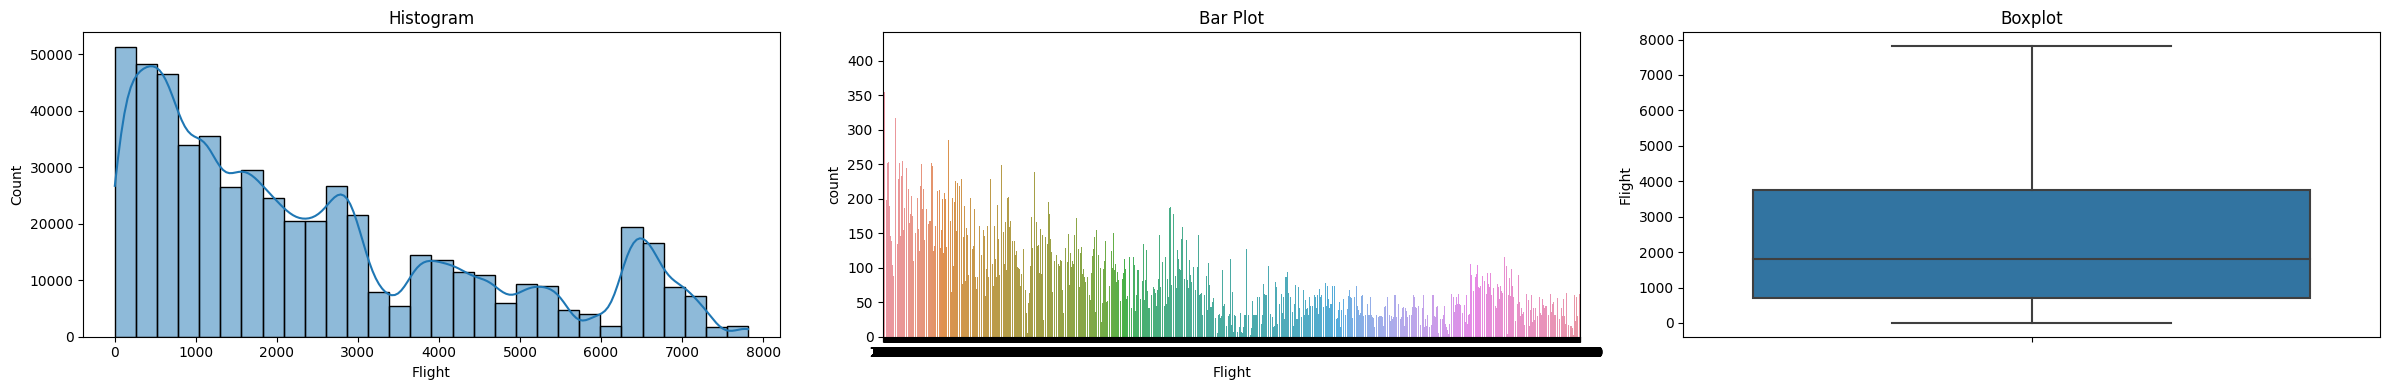

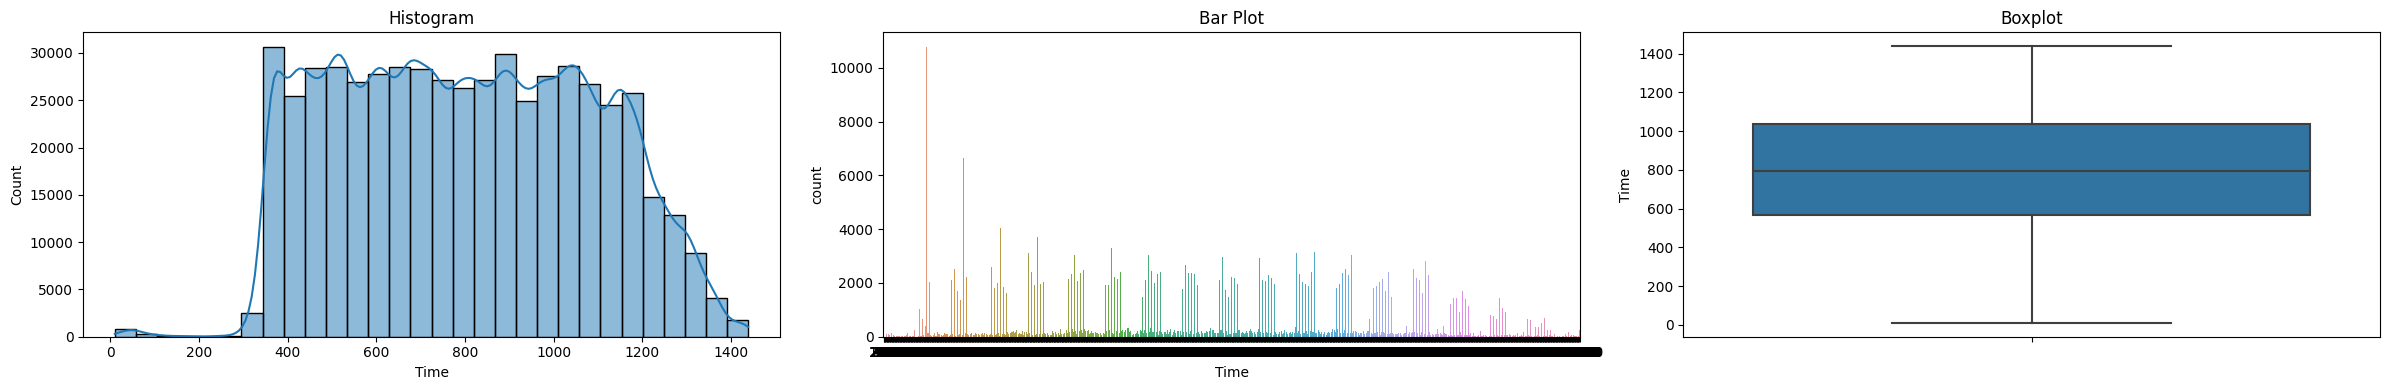

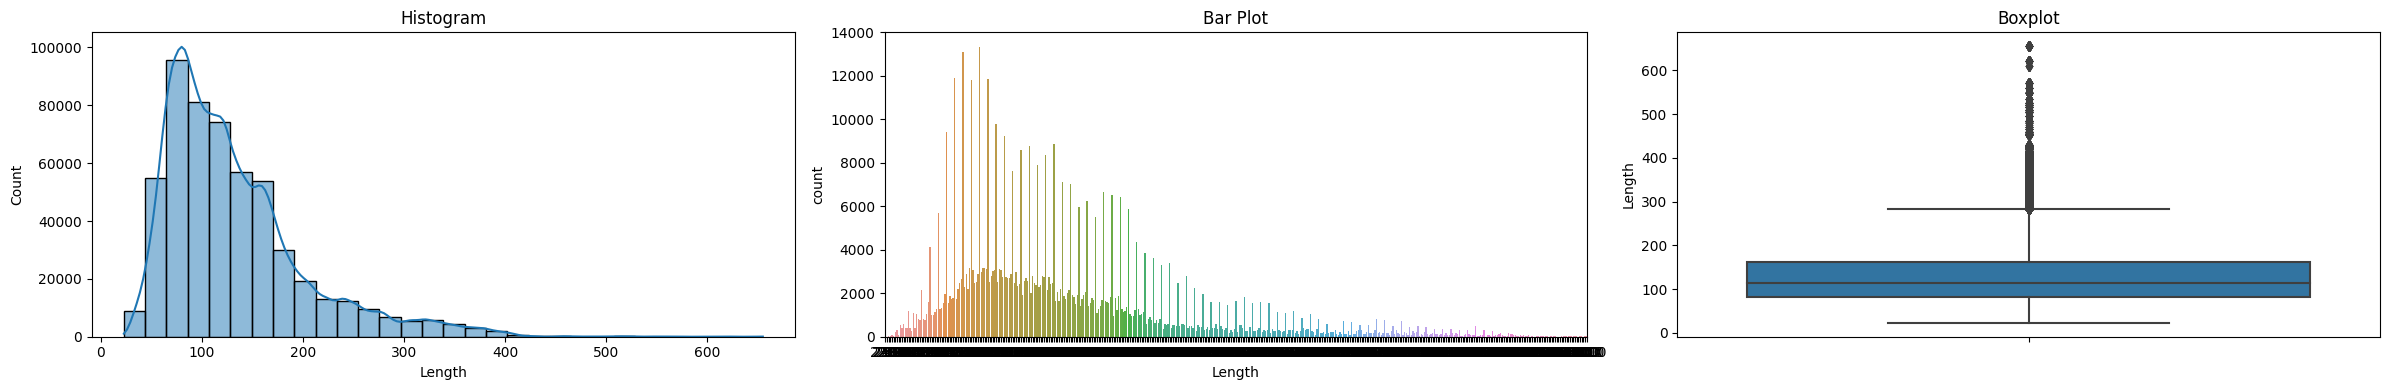

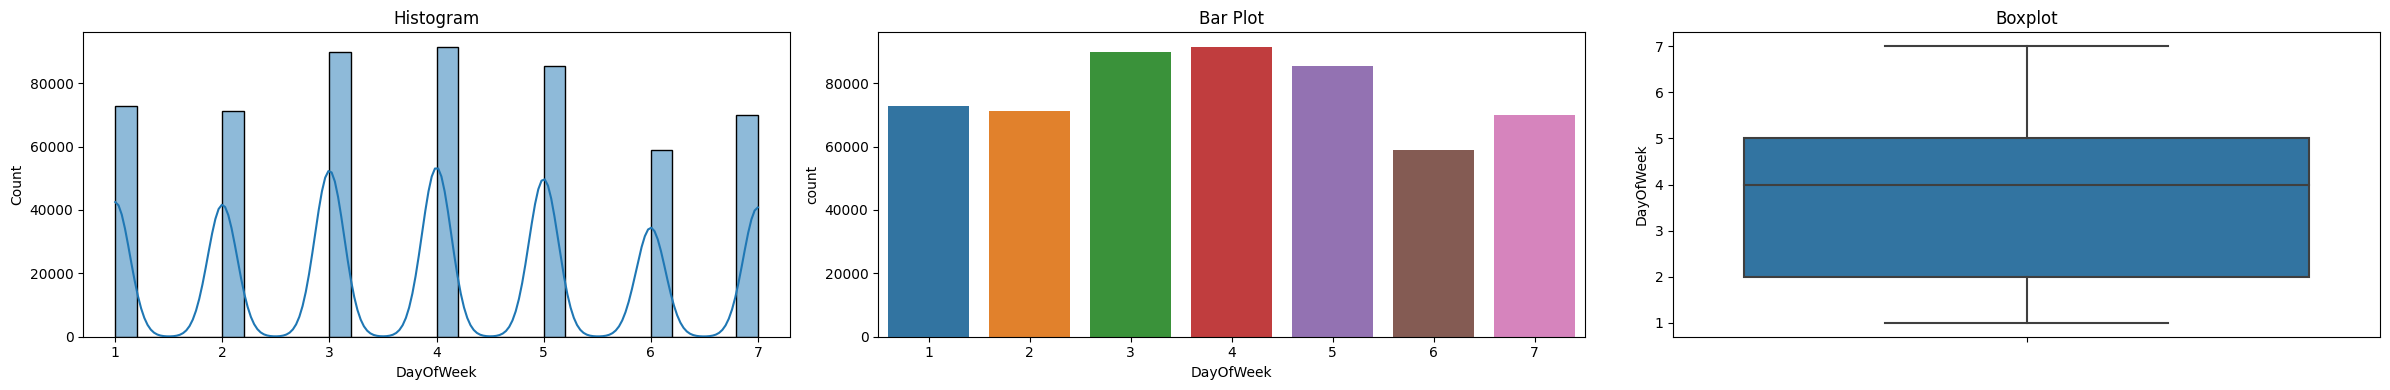

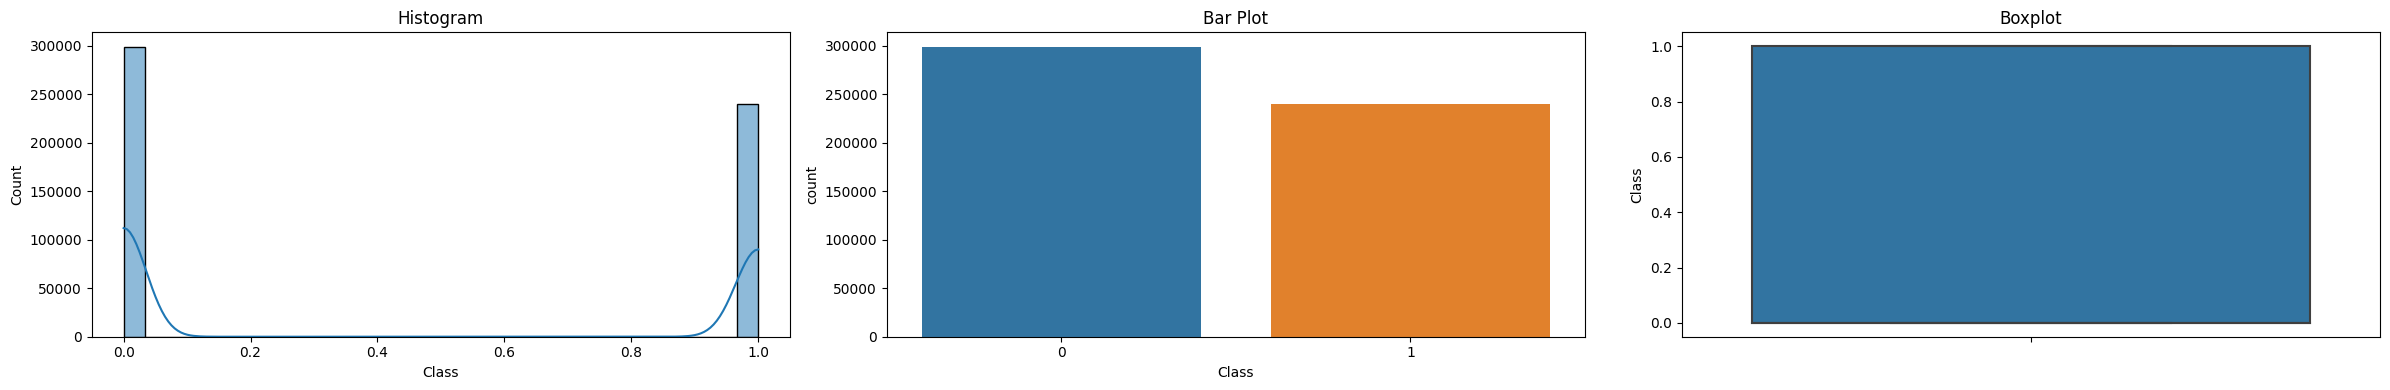

In [118]:
def plots(df, variable):
    if df[variable].dtype != object:
        # define figure size
        fig, ax = plt.subplots(1, 3, figsize=(24, 4))

        # histogram
        sb.histplot(df[variable], bins=30, kde=True, ax=ax[0])
        ax[0].set_title('Histogram')
        
        # bar plot
        sb.countplot(x=df[variable], ax=ax[1])
        ax[1].set_title('Bar Plot')

        # boxplot
        sb.boxplot(y=df[variable], ax=ax[2])
        ax[2].set_title('Boxplot')

        plt.tight_layout()
        plt.show()

for i in df.columns:
    plots(df, i)

In [119]:
value_percentages = df['Class'].value_counts(normalize=True) * 100

print(value_percentages)

Class
0    55.455543
1    44.544457
Name: proportion, dtype: float64


Since the split of the target class is 45:55, we can consider the target has a slight inbalance, but it's not significant

[Text(0.5, 1.0, 'Proportion of On-time vs Delayed Flights by Airline')]

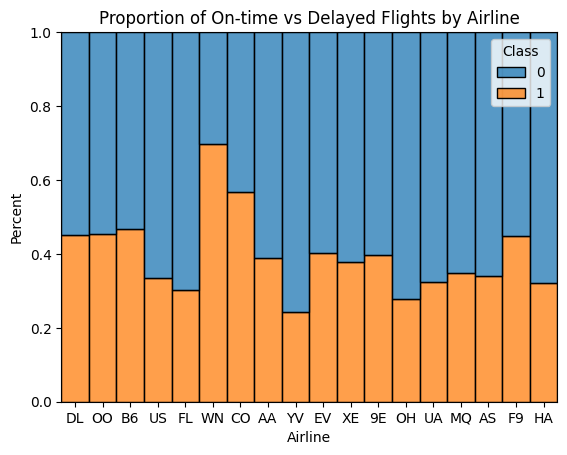

In [120]:
sb.histplot(data=df, x="Airline",
             stat="percent",
             multiple="fill",
             hue="Class").set(title='Proportion of On-time vs Delayed Flights by Airline')

As we can see in the graph, the airlines with a bigger proportion of delayed flights per flighs is the ailines **WN** and **CO**

[Text(0.5, 1.0, 'Proportion of On-time vs Delayed Flights by Time')]

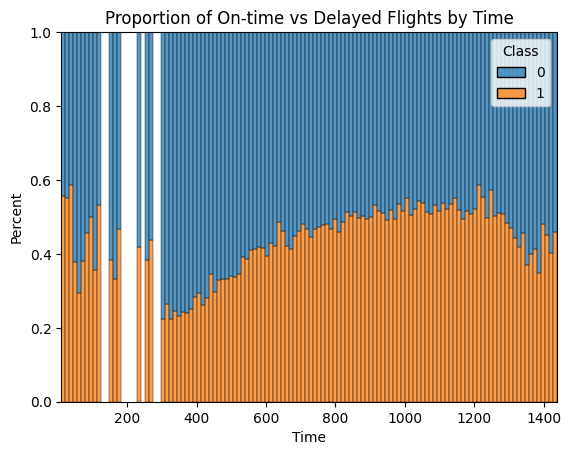

In [121]:
sb.histplot(data=df, x="Time", stat="percent", multiple="fill", hue="Class").set(title='Proportion of On-time vs Delayed Flights by Time')

[Text(0.5, 1.0, 'Proportion of On-time vs Delayed Flights by Origin Airport')]

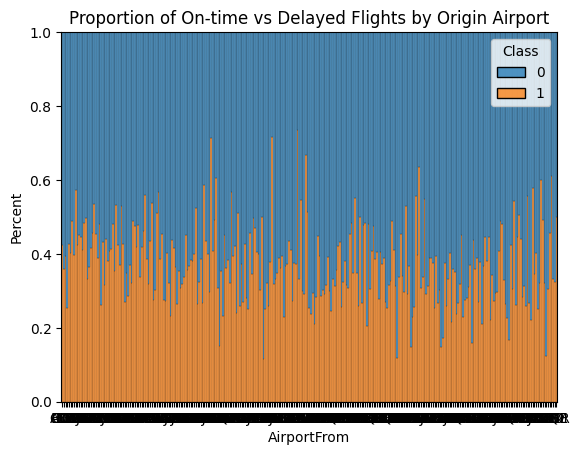

In [122]:
sb.histplot(data=df, x="AirportFrom",
             stat="percent",
             multiple="fill",
             hue="Class").set(title='Proportion of On-time vs Delayed Flights by Origin Airport')

[Text(0.5, 1.0, 'Proportion of On-time vs Delayed Flights by Destination Airport')]

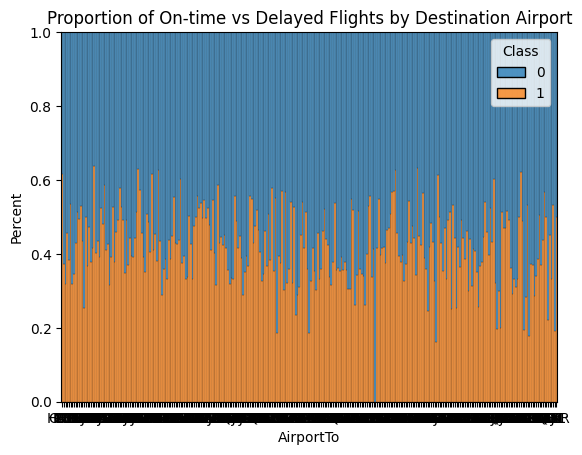

In [123]:
sb.histplot(data=df, x="AirportTo",
             stat="percent",
             multiple="fill",
             hue="Class").set(title='Proportion of On-time vs Delayed Flights by Destination Airport')

In this graph, we can see that most flights are on time during the morning, and it gets worse throughout the day

<Axes: xlabel='DayOfWeek', ylabel='Percent'>

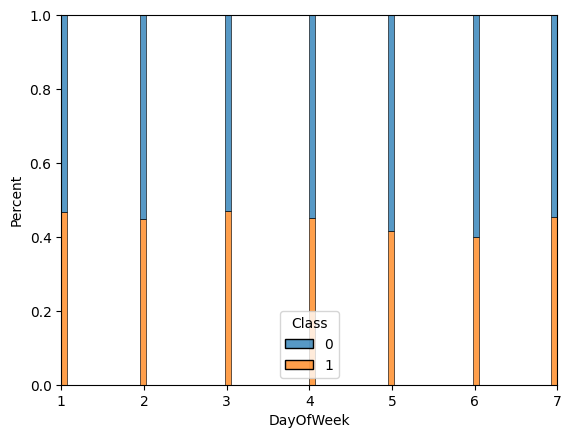

In [124]:
sb.histplot(data=df, x="DayOfWeek", stat="percent", multiple="fill", hue="Class")

There isn't an apparent difference in delays between different days of the week

### 1.2 Feature Engeneering

First we'll save the dataset

In [125]:
df.to_csv("CleanData/airlines-delay-clean.csv", index=False)

We don't think we have much room for joining or separating columns, but it could be interesting to see if the combination of the columns **AirportFrom** and **AirportTo** could be a bigger factor than the columns separated

In [126]:
df = pd.read_csv("CleanData/airlines-delay-clean.csv")

df['Airports'] = df[['AirportFrom', 'AirportTo']].apply('_'.join, axis=1)
new_df = df.drop(['AirportFrom', 'AirportTo'], axis=1)

new_df.head()

new_df.to_csv('CleanData/airlines-delay-clean-FE.csv', index=False)

### 1.3 Encoding

We also need to encode the categorical values to perform a correlation matrix and to apply the algorithms later

In [127]:
df = pd.read_csv("CleanData/airlines-delay-clean.csv")
df_fe = pd.read_csv("CleanData/airlines-delay-clean-FE.csv")
df['AirportTo']=LabelEncoder().fit_transform(df['AirportTo'])
df['AirportFrom']=LabelEncoder().fit_transform(df['AirportFrom'])
df['Airline']=LabelEncoder().fit_transform(df['Airline'])

df_fe['Airports']=LabelEncoder().fit_transform(df_fe['Airports'])
df_fe['Airline']=LabelEncoder().fit_transform(df_fe['Airline'])


In [128]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,5,16,129,1,0
1,6948.0,360.0,146.0,12,65,208,4,0
2,1247.0,1170.0,143.0,3,35,60,3,0
3,31.0,1410.0,344.0,14,203,217,6,0
4,563.0,692.0,98.0,8,32,16,4,0


In [129]:
df_fe.head()

,Flight,Time,Length,Airline,DayOfWeek,Class,Airports
0,2313.0,1296.0,141.0,5,1,0,152
1,6948.0,360.0,146.0,12,4,0,793
2,1247.0,1170.0,143.0,3,3,0,424
3,31.0,1410.0,344.0,14,6,0,2922
4,563.0,692.0,98.0,8,4,0,359


<Axes: >

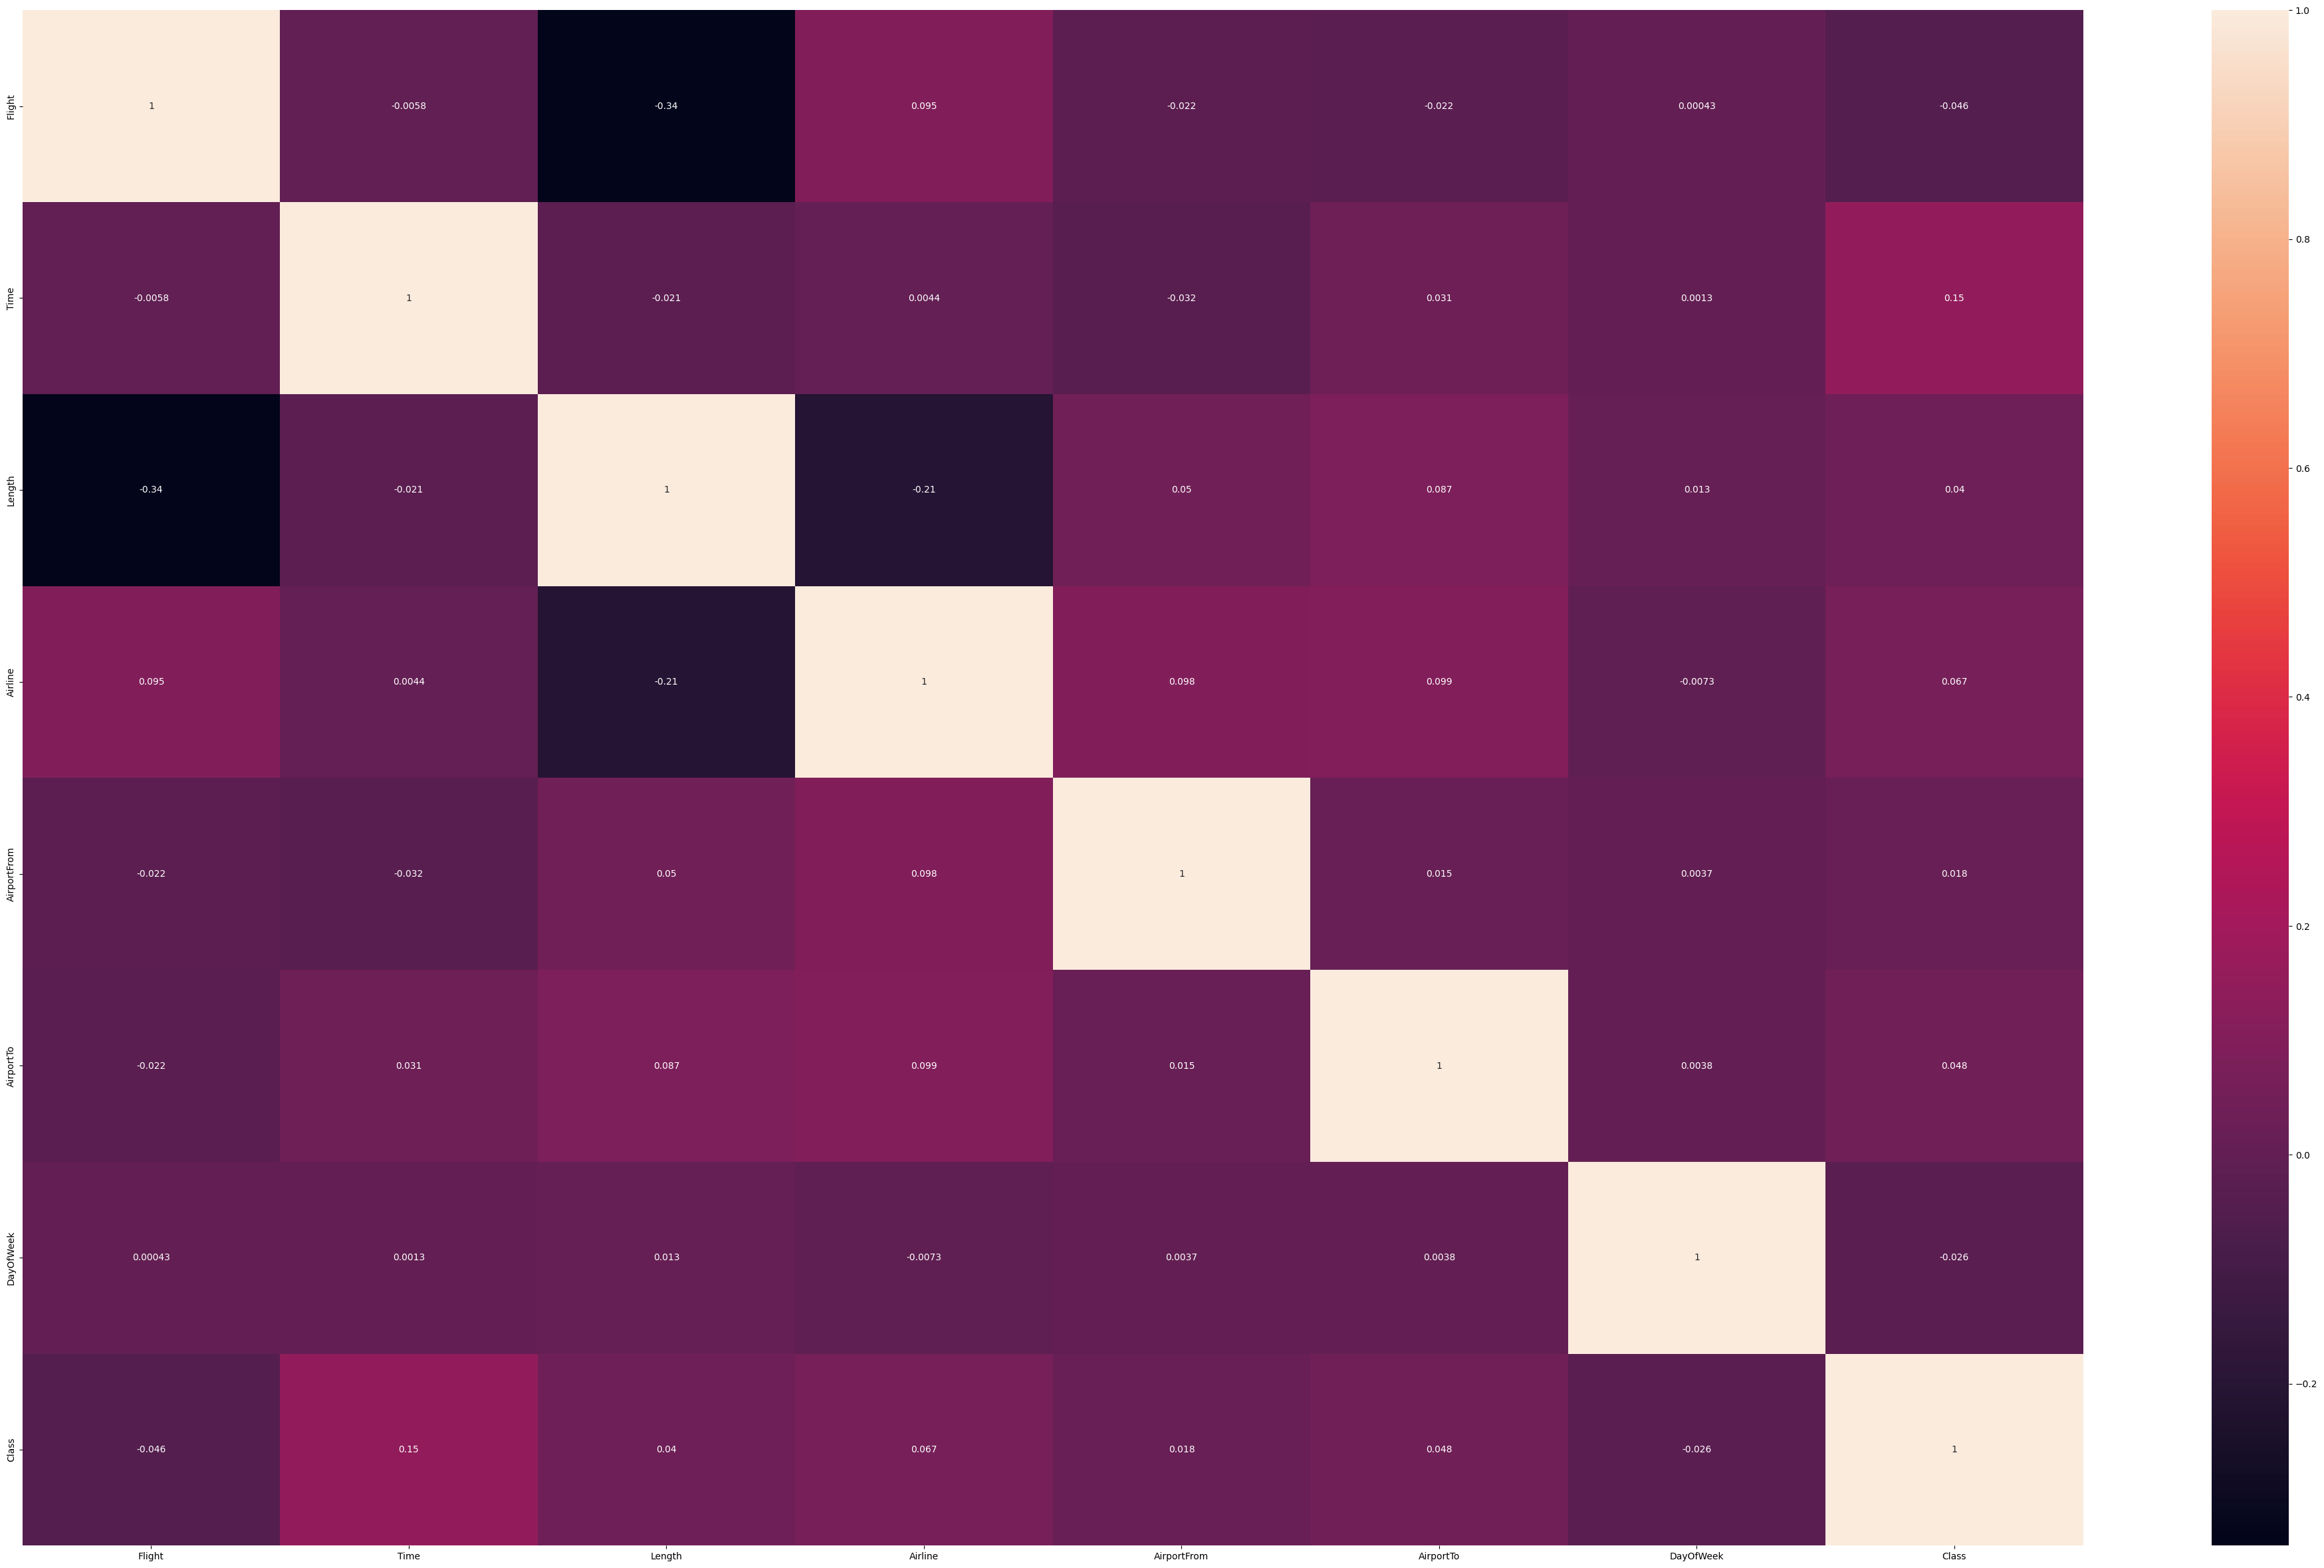

In [130]:
plt.figure(figsize=(50,30))
sb.heatmap(df.corr(),annot=True)

<Axes: >

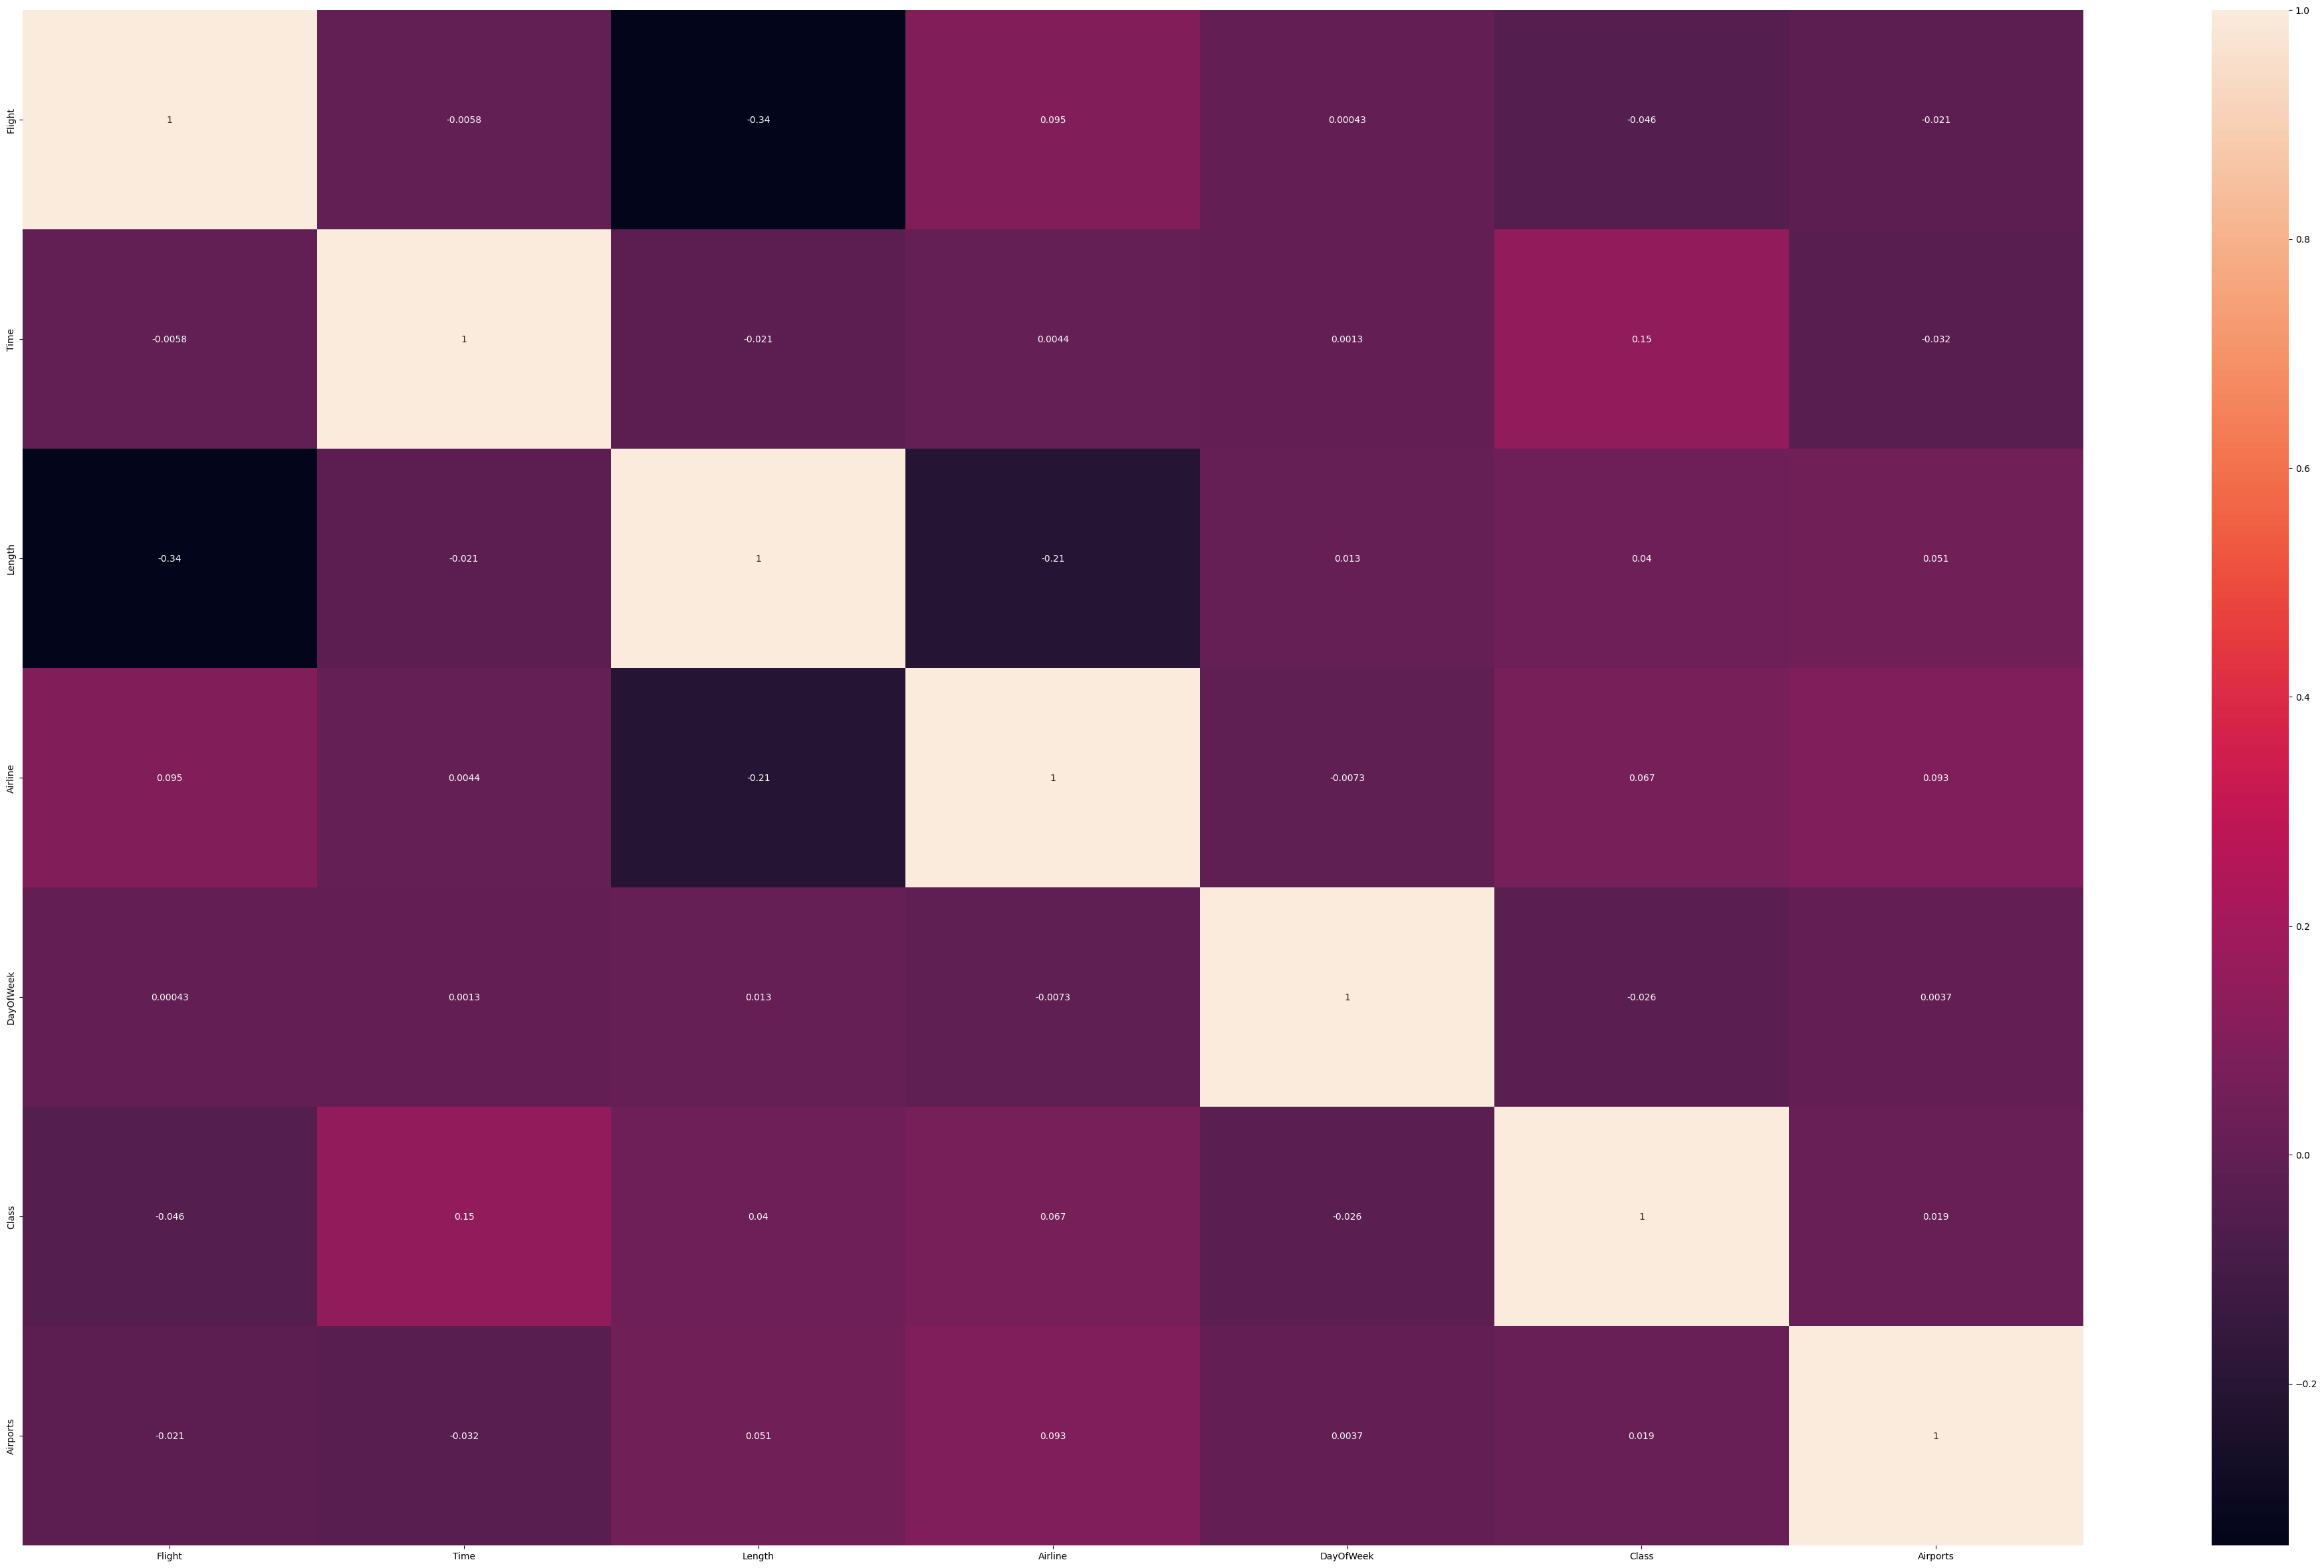

In [131]:
plt.figure(figsize=(50,30))
sb.heatmap(df_fe.corr(), annot=True)

In [132]:
df.to_csv('EncodedData/airlines-delay-clean-enc.csv', index=False)
df_fe.to_csv('EncodedData/airlines-delay-clean-FE-enc.csv', index=False)

### 1.4 Feature Scaling

We should encode the columns Time and Length since they are in a much larger scale than the other variables, which could negitavely affect the algorithms

In [133]:
df = pd.read_csv('EncodedData/airlines-delay-clean-enc.csv')
df_fe = pd.read_csv('EncodedData/airlines-delay-clean-FE-enc.csv')

scaler = MinMaxScaler()
df[['Time', 'Length']] = scaler.fit_transform(df[['Time', 'Length']])
df_fe[['Time', 'Length']] = scaler.fit_transform(df_fe[['Time', 'Length']])
df.to_csv('EncodedData/airlines-delay-scaled.csv', index=False)
df_fe.to_csv('EncodedData/airlines-delay-FE-scaled.csv', index=False)

In [134]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,0.899930,0.186709,5,16,129,1,0
1,6948.0,0.244927,0.194620,12,65,208,4,0
2,1247.0,0.811756,0.189873,3,35,60,3,0
3,31.0,0.979706,0.507911,14,203,217,6,0
4,563.0,0.477257,0.118671,8,32,16,4,0


In [135]:
df_fe.head()

,Flight,Time,Length,Airline,DayOfWeek,Class,Airports
0,2313.0,0.899930,0.186709,5,1,0,152
1,6948.0,0.244927,0.194620,12,4,0,793
2,1247.0,0.811756,0.189873,3,3,0,424
3,31.0,0.979706,0.507911,14,6,0,2922
4,563.0,0.477257,0.118671,8,4,0,359


### 1.5 Feature Selection

Lastly, we'll remove the columns that aren't relevant for the problem, in this case, the column Flight is an ID, so we should remove it

In [136]:
df = pd.read_csv('EncodedData/airlines-delay-scaled.csv')
df_fe = pd.read_csv('EncodedData/airlines-delay-FE-scaled.csv')

df = df.drop('Flight', axis=1)
df_fe = df_fe.drop('Flight', axis=1)

df.to_csv('FinalData/airlines-delay-final.csv', index=False)
df_fe.to_csv('FinalData/airlines-delay-FE-final.csv', index=False)

In [137]:
df.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,0.899930,0.186709,5,16,129,1,0
1,0.244927,0.194620,12,65,208,4,0
2,0.811756,0.189873,3,35,60,3,0
3,0.979706,0.507911,14,203,217,6,0
4,0.477257,0.118671,8,32,16,4,0


In [138]:
df_fe.head()

,Time,Length,Airline,DayOfWeek,Class,Airports
0,0.899930,0.186709,5,1,0,152
1,0.244927,0.194620,12,4,0,793
2,0.811756,0.189873,3,3,0,424
3,0.979706,0.507911,14,6,0,2922
4,0.477257,0.118671,8,4,0,359


## 2. Classification Models

For this section, we first need to separate the data into a training and a testing set. Then we need to apply models and lastly measure the performance.

We chose 4 algorithms: KNN, Decision Tree, Gradient Boosting and MultiLayer Perceptron.

For the first two algorithms, we also used cross validation to choose the best parameters. We also wanted to use it for the lasty two, but the time required to run was too big.

For all the algorithms, the metrics we chose were F1, Recall, Precision and Accuracy, since these are usually good metrics for classification problems. We also provided a confusion matrix for visualization purposes.

Lastly, we did each algorithm with the dataset with the columns Time, Length, AirportTo, AirportFrom, Airline, DayOfWeek and Class, and with the dataset that had the column Airports that resulted from the Feature Engeneering section, so that we could compare the two.

### 2.1 Defining Training and testing Sets

In [139]:
df = pd.read_csv('FinalData/airlines-delay-final.csv')
df_fe = pd.read_csv('FinalData/airlines-delay-FE-final.csv')

all_inputs = df.drop('Class', axis=1)
all_labels = df['Class']
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=42)

all_inputs_fe = df_fe.drop('Class', axis=1)
all_labels_fe = df_fe['Class']
(training_inputs_fe,
 testing_inputs_fe,
 training_classes_fe,
 testing_classes_fe) = train_test_split(all_inputs_fe, all_labels_fe, test_size=0.25, random_state=42)

### 2.2 K-Nearest Neighbors

First will use grid search to try to find the best parameters

#### Dataset 1 - Cross Validation

In [140]:
knn = KNeighborsClassifier()
knn.fit(training_inputs, training_classes)

knn_pred = knn.predict(testing_inputs)

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn, param_grid={'n_neighbors':[1,2,3,4,5,10,15]})

grid_search.fit(all_inputs, all_labels)

print('Best Score: {}'.format(grid_search.best_score_))
print('Best Parameters: {}'.format(grid_search.best_params_))


Best Score: 0.6414240103578861
Best Parameters: {'n_neighbors': 15}


#### Dataset 2 - Cross Validation

In [141]:
knn.fit(training_inputs_fe, training_classes_fe)

knn_pred = knn.predict(testing_inputs_fe)

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn, param_grid={'n_neighbors':[1,2,3,4,5,10,15]})

grid_search.fit(all_inputs_fe, all_labels_fe)

print('Best Score: {}'.format(grid_search.best_score_))
print('Best Parameters: {}'.format(grid_search.best_params_))

Best Score: 0.641490755219707
Best Parameters: {'n_neighbors': 15}


We'll now use those parameters to apply and measure the metrics for the algorithm. The same will be done for the next algorithm

#### Dataset 1 - Applying the Algorithm

Accuracy Score: 0.639512 %
Precision Score: 0.612442 %
Recall Score: 0.523366 %
F1 Score: 0.564411 %


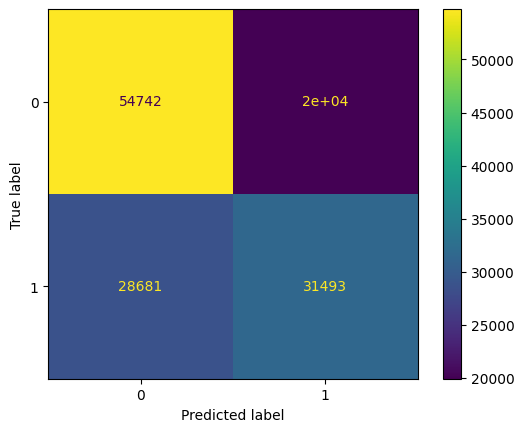

In [142]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(training_inputs, training_classes)

knn_pred = knn.predict(testing_inputs)

cm = confusion_matrix(testing_classes, knn_pred,labels=knn.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes, knn_pred)
precision = precision_score(testing_classes, knn_pred)
recall = recall_score(testing_classes, knn_pred)
f1 = f1_score(testing_classes, knn_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

#### Dataset 2 - Applying the Algorithm

Accuracy Score: 0.639608 %
Precision Score: 0.611870 %
Recall Score: 0.526141 %
F1 Score: 0.565776 %


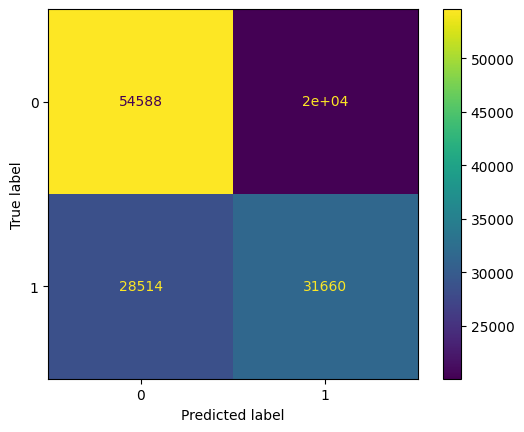

In [143]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(training_inputs_fe, training_classes_fe)

knn_pred = knn.predict(testing_inputs_fe)

cm = confusion_matrix(testing_classes_fe, knn_pred,labels=knn.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes_fe, knn_pred)
precision = precision_score(testing_classes_fe, knn_pred)
recall = recall_score(testing_classes_fe, knn_pred)
f1 = f1_score(testing_classes_fe, knn_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

### 2.3 Decision Tree

#### Dataset 1 - Cross Validation

In [144]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(training_inputs, training_classes)

dt_pred = dt.predict(testing_inputs)

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(dt, param_grid={'criterion':['gini', 'entropy'], 'splitter':['random', 'best'], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]})

grid_search.fit(all_inputs, all_labels)

print('Best Score: {}'.format(grid_search.best_score_))
print('Best Parameters: {}'.format(grid_search.best_params_))


Best Score: 0.647182496258633
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}


#### Dataset 2 - Cross Validation

In [145]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(training_inputs_fe, training_classes_fe)

dt_pred = dt.predict(testing_inputs_fe)

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(dt, param_grid={'criterion':['gini', 'entropy'], 'splitter':['random', 'best'], 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]})

grid_search.fit(all_inputs_fe, all_labels_fe)

print('Best Score: {}'.format(grid_search.best_score_))
print('Best Parameters: {}'.format(grid_search.best_params_))


Best Score: 0.6479426340194809
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}


#### Dataset 1 - Applying the Algorithm

Accuracy Score: 0.649041 %
Precision Score: 0.636375 %
Recall Score: 0.498205 %
F1 Score: 0.558877 %


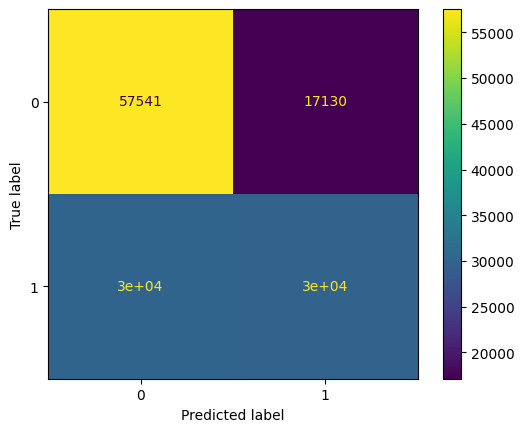

In [146]:
dt = DecisionTreeClassifier(max_depth=10, random_state = 42)
dt.fit(training_inputs, training_classes)

dt_pred = dt.predict(testing_inputs)

cm = confusion_matrix(testing_classes, dt_pred, labels=dt.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes, dt_pred)
precision = precision_score(testing_classes, dt_pred)
recall = recall_score(testing_classes, dt_pred)
f1 = f1_score(testing_classes, dt_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

#### Dataset 2 - Applying the Algorithm

Accuracy Score: 0.650584 %
Precision Score: 0.657712 %
Recall Score: 0.452455 %
F1 Score: 0.536108 %


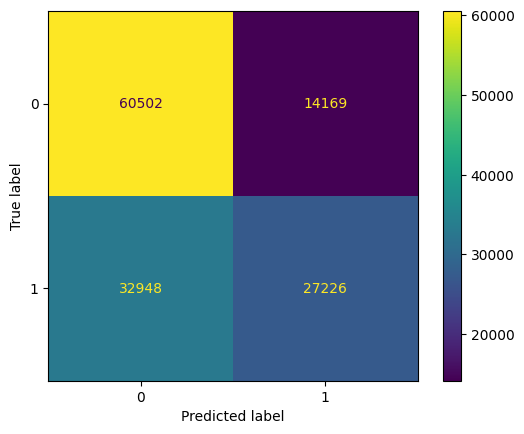

In [147]:
dt = DecisionTreeClassifier(max_depth=10, random_state = 42)
dt.fit(training_inputs_fe, training_classes_fe)

dt_pred = dt.predict(testing_inputs_fe)

cm = confusion_matrix(testing_classes_fe, dt_pred, labels=dt.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes_fe, dt_pred)
precision = precision_score(testing_classes_fe, dt_pred)
recall = recall_score(testing_classes_fe, dt_pred)
f1 = f1_score(testing_classes_fe, dt_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

### 2.4 Gradient Boosting

#### Dataset 1 - Applying the Algorithm

Accuracy Score: 0.646876 %
Precision Score: 0.672719 %
Recall Score: 0.406388 %
F1 Score: 0.506687 %


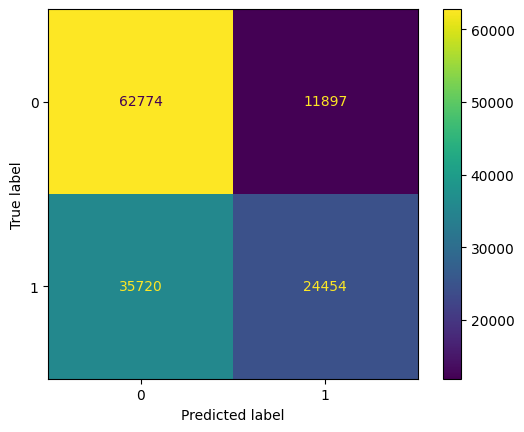

In [150]:
gbc = GradientBoostingClassifier(random_state = 42)
gbc.fit(training_inputs, training_classes)

gbc_pred = gbc.predict(testing_inputs)

cm = confusion_matrix(testing_classes, gbc_pred, labels=gbc.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes, gbc_pred)
precision = precision_score(testing_classes, gbc_pred)
recall = recall_score(testing_classes, gbc_pred)
f1 = f1_score(testing_classes, gbc_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

#### Dataset 2 - Applying the Algorithm

Accuracy Score: 0.646639 %
Precision Score: 0.672983 %
Recall Score: 0.404892 %
F1 Score: 0.505598 %


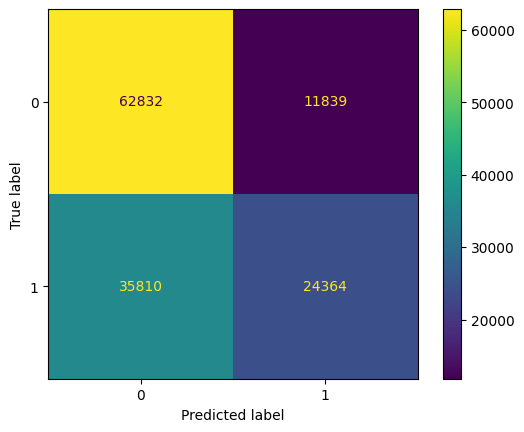

In [154]:
gbc = GradientBoostingClassifier(random_state = 42)
gbc.fit(training_inputs_fe, training_classes_fe)

gbc_pred = gbc.predict(testing_inputs_fe)

cm = confusion_matrix(testing_classes_fe, gbc_pred, labels=gbc.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes_fe, gbc_pred)
precision = precision_score(testing_classes_fe, gbc_pred)
recall = recall_score(testing_classes_fe, gbc_pred)
f1 = f1_score(testing_classes_fe, gbc_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

### 2.5 Neural Network

#### Dataset 1 - Applying the Algorithm

Accuracy Score: 0.605273 %
Precision Score: 0.582799 %
Recall Score: 0.406305 %
F1 Score: 0.478805 %


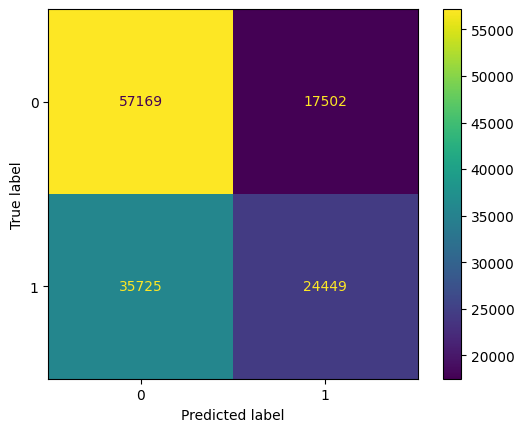

In [162]:
mlp = MLPClassifier(random_state = 42)
mlp.fit(training_inputs, training_classes)

mlp_pred = mlp.predict(testing_inputs)

cm = confusion_matrix(testing_classes, mlp_pred, labels=mlp.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes, mlp_pred)
precision = precision_score(testing_classes, mlp_pred)
recall = recall_score(testing_classes, mlp_pred)
f1 = f1_score(testing_classes, mlp_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

#### Dataset 2 - Applying the Algorithm

Accuracy Score: 0.582877 %
Precision Score: 0.537482 %
Recall Score: 0.467910 %
F1 Score: 0.500289 %


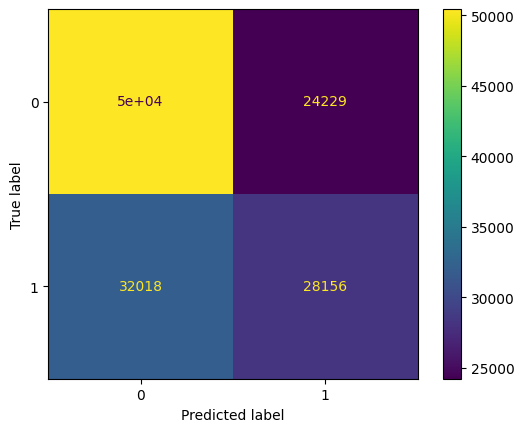

In [164]:
mlp = MLPClassifier(random_state = 42, max_iter=300)
mlp.fit(training_inputs_fe, training_classes_fe)

mlp_pred = mlp.predict(testing_inputs_fe)

cm = confusion_matrix(testing_classes_fe, mlp_pred, labels=mlp.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)

cm_disp.plot()

accuracy = accuracy_score(testing_classes_fe, mlp_pred)
precision = precision_score(testing_classes_fe, mlp_pred)
recall = recall_score(testing_classes_fe, mlp_pred)
f1 = f1_score(testing_classes_fe, mlp_pred)

print(f"Accuracy Score: {accuracy:2f} %")
print(f"Precision Score: {precision:2f} %")
print(f"Recall Score: {recall:2f} %")
print(f"F1 Score: {f1:2f} %")

## 3. Conclusions and Comparisons

From the results we have, we can see the differences between algorithms and between the wo datasets tried are not very significant.

In the table below, we can see the accuracies don't vary that much (between 58.29% and 65.06%). The same can be said for the other metrics.

With this in mind, we think the algorithm most suited in this case is the Decision Tree Algorithm, not only because it was the one with the best accuracies and better measure, but also because the others required to many computational resources for almost the same results.

|           | KNN   | KNN - FE | DT    | DT - FE | GBC   | GBC - FE | MLP   | MLP - FE |
|-----------|-------|----------|-------|---------|-------|----------|-------|----------|
| Accuracy  | 63.95 | 63.96    | 64.90 | 65.06   | 64.69 | 64.66    | 60.53 | 58.29    |
| Precision | 61.24 | 61.19    | 63.63 | 65.77   | 67.27 | 67.30    | 58.28 | 53.74    |
| Recall    | 52.33 | 52.61    | 49.82 | 45.26   | 40.64 | 40.49    | 40.63 | 46.79    |
| F1        | 56.44 | 56.58    | 55.89 | 53.61   | 50.67 | 50.56    | 47.88 | 50.03    |

Table: Metrics from all the algorithms

Of course, with some adjustments in the parameters, some of the other algorithms tried could obtain better results. Some other algorithms could also be applied to try to obtain better result.